# Auteur : PAMBOU MOUBOGHA Eddy Vianney
# Etudes : Master Sciences des Donnees et Systèmes Complexes
# Ecole : Université de Strasbourg
# Sujet :  Detection de glissements de terrain

In [432]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
from datetime import date, datetime
import datetime
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import multiprocessing
import itertools
import operator
import math
from dtaidistance import dtw
import seaborn as sns
plt.style.use('fivethirtyeight')

# Attributs des fichiers MM_TIO

* Lat : latitude (degré)
* Lon : longitude (degré)
* Vel : vitesse (mètre/jour)
* Topo : altitude d'un point (mètre)
* TS : serie temporelles de déplacement (mètre)

In [64]:
DATA_PATH = './donnees'

# Paramètres des géométries ascendante et descendante

In [264]:
# angle d'incidence du satellite en géométrie ascendante (angle entre la vertical et la direction du  satellite)
theta_asc = 0
# angle d'incidence du satelitte en géométrie descendante (angle entre la vertical et la direction du satellite)
theta_desc = 0
# difference angulaire des orbites des géométries ascendante et descendante
delta_alpha =  0
# déplacement le long de la ligne de visée en géométrie ascendante
d_los_asc = 0
# déplacement le long de la ligne de visée en géométrie descendante
d_los_dsc = 0
# # déplacement vertical
d_up = 0

# Chargement des données

In [436]:
def to_date(str):
    str_strp = str.strip()
    year, month, day = int(str_strp[0:4]), int(str_strp[4:6]), int(str_strp[6:8])
    return date(year, month, day)

def load_data(filename):

    # numéro de la ligne ou commence les données
    num_start = 44
    # numéro de la ligne ou se trouve la liste des dates
    num_list_dates = 40
    # attributs présent dans les données
    columns = ['id', 'Lat','Lon', 'Topo', 'Vel', 'Coer',' CosN', 'CosE', 'CosU']
    # dictionnaire stockant les données
    data = {column: [] for column in columns}
    # liste des dates 
    indexes = []
    # series temporelles
    series = []
    # liste de dataframes
    df_series = []

    with open(DATA_PATH + '/' + filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=",")
        line_count = 1 
        for row in csv_reader:
            if line_count == num_list_dates:
                indexes = [row[0].split(' ')[1]] + row[1:]
            if line_count >= num_start:
                # extraction des premiers attributs
                for i in range(len(columns)):
                    data[columns[i]].append(row[i])
                # extraction de l'attribut TS(série temporelle)
                series.append([float(v) for v in row[len(columns):]])
            line_count  += 1
        if len(indexes) != len(series[0]):
            print('Erreur : Les indexes et les valeurs ne correspondent pas')
        # convertir les index en date
        indexes = [d.strip()[0:8] for d in indexes]
        # créer une liste de dataframes, chacun contenant une série temporelle
        for serie in series:
            tmp_serie = pd.DataFrame({'displacement': pd.Series(serie, index=pd.DatetimeIndex(indexes))})
            tmp_serie.sort_index(inplace=True)
            df_series.append(tmp_serie)
        # creer un dataframe pour les autres attributs
        df = pd.DataFrame(data)
        for column in df.columns:
            df[column] = pd.to_numeric(df[column], errors='coerce')
        df.set_index('id')
        
    return df, df_series

# imputer les données
def impute(ns_series, ew_series, pc=0.4):

    # nombre de mésures
    n = len(ns_series[0])
    
    # recupérer les series de la composante Nord-Sud qui ont un pourcentage de valeurs manquuantes inferieur à 50%
    ns_booleans  = [True if (ns_series[i].isnull().sum().sum()/n) < pc else False for i in range(len(ns_series))]
    # recupérer les series de la composante Est-Ouest qui ont un pourcentage de valeurs manquuantes inferieur à 50%
    ew_booleans  = [True if (ew_series[i].isnull().sum().sum()/n) < pc else False for i in range(len(ew_series))]
    # Conserver uniquement les points où la norme du vecteur vitesse est calculable
    booleans     = [True if i and j else False for i, j in zip(ns_booleans, ew_booleans)]
    
    # suppression des séries temporelles qui ont un pourcentage de valeurs manquantes supérieure ou égale à 0.5
    ns_series_c = [d for d in itertools.compress(ns_series, booleans)]
    ew_series_c = [d for d in itertools.compress(ew_series, booleans)]
    
    # interpoler les valeurs manquantes des les séries restantes
    for i in range(len(ns_series_c)):
        if ns_series_c[i].isnull().sum().sum() > 0:
            ns_series_c[i].interpolate(limit_direction='both', inplace=True)
        if ew_series_c[i].isnull().sum().sum() > 0:
            ew_series_c[i].interpolate(limit_direction='both', inplace=True)
            
    return ns_series_c[0].index, ew_series_c, ns_series_c

In [499]:
# chargement de la composante  Est-Ouest du mouvement du sol
df_ew, df_ew_ts = load_data('MM_TIO_EW_31TGK_20151227_to_20200906.csv')
# chargement de la composante Nord-Sud du mouvement du sol
df_ns, df_ns_ts = load_data('MM_TIO_NS_31TGK_20151227_to_20200906.csv')

In [ ]:
# fusion des deux composantes 


# Visualisation 

In [494]:
#from datetime import datetime
Y = 2000
seasons  = [('winter', date(Y,  1,  1), date(Y,  3, 20)),
           ('spring', date(Y,  3, 21),  date(Y,  6, 20)),
           ('summer', date(Y,  6, 21),  date(Y,  9, 22)),
           ('autumn', date(Y,  9, 23),  date(Y, 12, 20)),
           ('winter', date(Y, 12, 21),  date(Y, 12, 31))]


def get_season(date):
    
    for season in seasons:
        name  = season[0]
        start = season[1].replace(year=date.year)
        end   = season[2].replace(year=date.year)
        if start <= date <= end:
            return name
        
def count_samples_per_season(dates):
    
    samples_per_season = {'winter': 0, 'spring': 0, 'summer': 0, 'autumn': 0}
    for date in dates:
        samples_per_season[get_season(date)] += 1
        
    return samples_per_season

def plot_data_per_season(labels, values):

    fig1, ax1 = plt.subplots(figsize=(5,5))
    ax1.pie(values, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal') 

    plt.show()
    
def get_days(dates):
    days = []
    for i in range(len(dates)):
        days.append(abs((dates[0] - dates[i]).days ))
    return days

def plot_displacement(ns_ts, ew_ts):
    
    days = get_days(ns_ts.index)
    fig, ax = plt.subplots(figsize=(15,5))
    
    ax.plot(days, ns_ts['displacement'], color='blue', label='NS displacement (m)', marker='o', linewidth=2)
    ax.plot(days, ew_ts['displacement'], color='orange', label='EW displacement (m)', marker='o', linewidth=2)
    
    plt.legend(loc='best')
    
def plot_displacement_velocity(ns_ts, ew_ts):

    days = get_days(ns_ts[0].index)

    fig, ax_left = plt.subplots(figsize=(15,5))
    ax_right = ax_left.twinx()

    p1, = ax_left.plot(days, df_series[4]['displacement'], color='blue', label='NS displacement (m)')
    p2, = ax_right.plot(days, df_series[4]['displacement'], color='orange', label='EW displacement(m)')

    ax_left.set_xlabel("number of days since the first measure")
    ax_left.set_ylabel("displacement")
    ax_right.set_ylabel("velocity")

    lns = [p1, p2]

    ax_left.legend(handles=lns, loc='best')
    fig.tight_layout()
    plt.show()

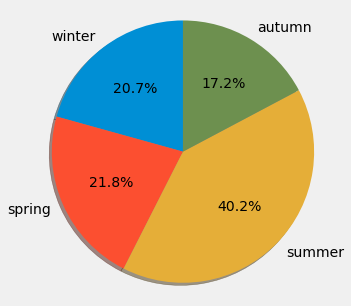

In [14]:
r = count_samples_per_season(df_ew_ts[0].index)
plot_data_per_season(list(r.keys()), list(r.values()))

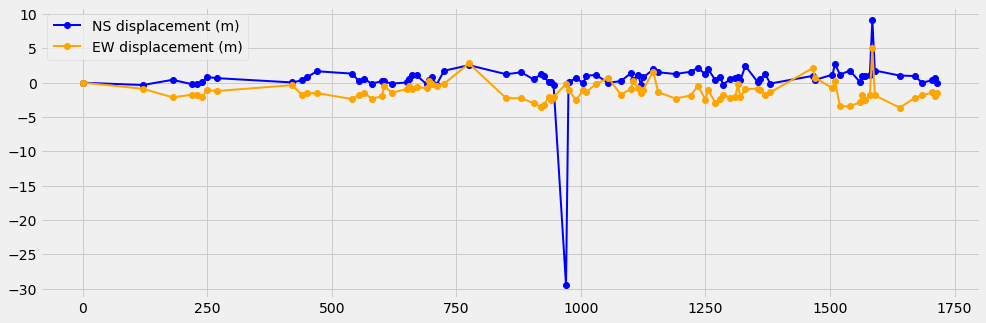

In [270]:
# visualiser les composantes NS et EW sur le mêmes graphique
n = 59800
plot_displacement(ns_ts[n], ew_ts[n])

# Nettoyage des données et détection d'anomalies

In [549]:
# imputer les valeurs manquantes
indexes, ew_ts, ns_ts = impute(df_ew_ts, df_ns_ts)

# Calcul de vitesses à partir des composantes Nord-Sud et Est-Ouest du mouvement

In [495]:
def compute_instantaneous_velocity(series):
    n = len(series)
    m = len(series[0])
    for i in range(n):
        for j in range(1, m-1):
            try:
                duration = (series[i].index[j+1] - series[i].index[j-1]).days
                displacement = series[i].iloc[j+1]['displacement'] - series[i].iloc[j-1]['displacement']
                series[i].loc[series[i].index[j], 'velocity'] = displacement / duration
            except:
                continue

def compute_inst_vel(serie):
    
    vels = []
    
    for j in range(1, len(serie)-1):
        duration = (serie.index[j+1] - serie.index[j-1]).days
        displacement = serie.iloc[j+1]['displacement'] - serie.iloc[j-1]['displacement']
        vels.append(displacement / duration)
    # supprimer le premier et le dernier index (formule non applicable)
    return pd.DataFrame(vels, index=serie.index[1:-1], columns=['vel'])
    
def compute_velocity(ns_component, ew_component):
    return math.sqrt(ns_component*ns_component + ew_component*ew_component)

# créer les séries temporelles de vitesse instantanée
def compute_magnitude(ns_vel_ts, ew_vel_ts):
    
    magnitudes = []
    indexes = ns_vel_ts[0].index
    
    for i in range(len(ns_vel_ts)):
        vels = []
        for ns_component, ew_component in zip(ns_vel_ts[i]['vel'], ew_vel_ts[i]['vel']):
            vels.append(compute_velocity(ns_component, ew_component))
        df = pd.DataFrame(vels, index=indexes, columns=['magnitude'])
        magnitudes.append(df)
        
    return magnitudes

In [461]:
n_cores = multiprocessing.cpu_count()

def compute_inst_vels(series, n_cores=n_cores):
    
    with multiprocessing.Pool(n_cores) as p:
        results = p.map(compute_inst_vel , series)
        return results

In [462]:
# calcul des vitesses instantanées sur chaque composante
ns_vel_ts = compute_inst_vels(ns_ts[:10])
ew_vel_ts = compute_inst_vels(ew_ts[:10])

# calcul de la magnitude du vecteur vitesse instantanée
magnitude_ts = compute_magnitude(ns_vel_ts, ew_vel_ts)

In [ ]:
plot_series(magnitude_ts)

In [190]:
# calculer la vitesse instantanée sur chaque composante
# calculer le module de la vitesse 

# Calcul de la vitesse instannée

In [49]:
def get_days(dates):
    days = []
    for i in range(len(df_series[0])):
        days.append(abs((dates[0] - dates[i]).days ))
    return days
 
def plot_displacement_velocity(indexes):

    days = get_days(indexes)

    fig, ax_left = plt.subplots(figsize=(15,5))
    ax_right = ax_left.twinx()

    p1, = ax_left.plot(days, df_series[4]['displacement'], color='red', label='displacement (m)')
    p2, = ax_right.plot(days, df_series[4]['velocity'], color='green', label='velocity (m/day)')

    ax_left.set_xlabel("number of days since the first measure")
    ax_left.set_ylabel("displacement")
    ax_right.set_ylabel("velocity")

    lns = [p1, p2]

    ax_left.legend(handles=lns, loc='best')
    fig.tight_layout()
    plt.show()

In [98]:
y = df_series[0]['deplacement']

fig, ax = plt.subplots(figsize=(15,5))

season_colors = {season : color for (season, color) in zip(('winter', 'spring', 'summer', 'autumn'), ('green', 'purple', 'yellow', 'blue'))}
seasons_count = {season : 0 for season in ('winter', 'spring', 'summer', 'autumn')}
colors  = []
sample_seasons = []

for sample_date in df_series[0].index:
        sample_seasons.append(get_season(sample_date))
for season in sample_seasons:
    colors.append(season_colors[season])

for i in range(len(df_series[0])):
    ax.plot(df_series[0].iloc[0].name, df_series[0].iloc[0].deplacement, 'k', color=colors[i], marker='o')
    
ax.grid()
ax.margins(0)
    
plt.grid()
plt.legend()
plt.show()

NameError: name 'df_series' is not defined

In [77]:
import simplekml
kml=simplekml.Kml()
style = simplekml.Style()
style.labelstyle.color = simplekml.Color.red  
style.labelstyle.scale = 2
style.iconstyle.icon.href = 'http://maps.google.com/mapfiles/kml/shapes/placemark_circle.png'
for index, row in df.iterrows():
    kml.newpoint(name=row['Vel'], coords=[(row['Lat'], row['Lon'], row['Topo'])])
kml.save('ps.kml')  

NameError: name 'df' is not defined

In [99]:
num_rows = 6
num_cols = 4

def plot_series(series, num_rows=num_rows, num_cols=num_cols, colormap='tab20'):
plot_kwds = {'alpha' : 0.25, 's' : 10, 'linewidths':0}
    fig, axs = plt.subplots(num_rows,num_cols,figsize=(25,25))
    cmap = plt.get_cmap(colormap)
    colors = [cmap(i) for i in np.linspace(0,1,num_rows*num_cols)]

    for num_row in range(num_rows):
        for num_col in range(num_cols):
            if num_row*num_cols + num_col < len(series):
                axs[num_row, num_col].plot(series[num_row*num_cols + num_col],color=colors[num_row*num_cols + num_col], marker='o', markerfacecolor='white')
                #axs[num_row, num_col].set_title('serie: %s'%(self.names[num_row*num_cols + num_col].split('.')[0]))

    plt.show()

# Etude de la saisonnalité

# Réechantillonage des données

## Test de Dickey-Fuller augmenté (ADF)
La série temporelle est considérée comme stationnaire si la valeur p est faible (selon l’hypothèse nulle) et si les valeurs critiques à des intervalles de confiance de 1%, 5%, 10% sont aussi proches que possible des statistiques de l’ADF (Augmented Dickey-Fuller)

In [7]:
from statsmodels.tsa.stattools import adfuller

In [81]:
def impute_time_series(serie):
    if serie.isnull().sum().sum() > 0:
        return serie.interpolate(limit_direction="both",inplace=False)
    else:
        return serie
    
def get_non_stationary(series, alpha=0.05, nb_nan_max=87):
    
    # nombre de series temporelles
    n_series = len(series)
    # liste contenant les indinces des séries temporelles non stationnaires
    non_stationary_series = []
    
    for i in range(len(series)):
        # imputer les series qui ont moins de nb_nan_max valeurs manquantes
        if series[i].isnull().sum().sum() < nb_nan_max: 
            serie = impute_time_series(series[i])
            result = adfuller(serie['displacement'])
            # le test de stationarité échoue automatiquement si la p-value est supérieure à 0.05
            if result[1] > alpha:
                non_stationary_series.append(i)
            
    return non_stationary_series

In [ ]:
 non_stationary_index = get_non_stationary(df_series)

In [137]:
non_stationary_series = []
for i in range(len(non_stationary_index)):
    non_stationary_series.append(df_series[non_stationary_index[i]])

In [ ]:
plot_series(non_stationary_series[0:50])

# Significativité des régressions linéaires
* p-value : probabilité que la pente soit nulle
* Hypothèse nulle HO : la pente de la droite de regression est nulle  (vitesse moyenne non significative)
* si la p-value est inférieure à 0.05 alors l'hypothèse nulle est rejetée (vitesse moyenne est significative).

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [10]:
reg = LinearRegression()
reg.fit(df_series[0].index.values.reshape(-1,1), df_series[0]['displacement'].values.reshape(-1,1))

LinearRegression()

## Décomposition en composantes indépendantes

In [470]:
transformer = FastICA(n_components=3, random_state=0)
X_transformed = transformer.fit_transform(ns_ts[0].values)

/home/eost-user/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:468: UserWarning: n_components is too large: it will be set to 2
  warnings.warn(


In [539]:
from sklearn.decomposition import FastICA, PCA

# #############################################################################
# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

In [541]:
S_.shape

(2000, 3)

In [483]:
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA

X, _ = load_digits(return_X_y=True)
transformer = FastICA(n_components=7, random_state=0)
X_transformed = transformer.fit_transform(X)
X_transformed.shape

/home/eost-user/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


(1797, 7)

In [546]:
X = np.array(ns_ts)

In [548]:
def reshape(series):
    
    result = []
    n = len(series[0])
    
    for i in range(len(series)):
        result.append(series[i].values.reshape(n))
        
    return np.array(result)
    

In [566]:
X = reshape(ns_ts)

In [611]:
t = PCA(12)
t.fit(X)

PCA(n_components=12)

In [610]:
s = 0.0
for i in range(len(t.explained_variance_ratio_)):
    s += t.explained_variance_ratio_[i]
    print(s*100, i)

38.335310282464306 0
57.133264684720196 1
63.1557412803219 2
68.57547896883244 3
72.96861473846894 4
76.7229005273822 5
80.13456712438737 6
83.08582654665099 7
85.40221686142047 8
87.06199925355854 9
88.54768900377852 10
89.60200034834618 11
90.50284684417747 12
91.35232871034391 13
92.11650451545081 14
92.71120058024987 15
93.22636936849482 16
93.64851566271567 17
94.05180533197073 18
94.40963566562988 19
94.75367765414772 20
95.07407623276742 21
95.36093268993687 22
95.61219818306773 23
95.85774840890622 24
96.08522311597159 25
96.28822610144199 26
96.47725612716033 27
96.65145399021242 28
96.82227140305329 29
96.97904870380974 30
97.1225606098597 31
97.2595373632519 32
97.38682325720987 33
97.50931329489885 34
97.6289557469178 35
97.74134840921232 36
97.84906563981289 37
97.94977410502518 38
98.04635935385119 39
98.13977185981196 40
98.23049044872387 41
98.31874978450071 42
98.40054945792527 43
98.48147489364547 44
98.55742540293988 45
98.63210109626709 46
98.70162160366152 47
98.77

In [515]:
transformer = FastICA(n_components=7, random_state=0)
X_transformed = transformer.fit_transform(X)

In [542]:
X.shape

(2000, 3)

# Classification des séries temporelles

Si on ne s'interesse qu'à la forme des séries, il faut normaliser avant d'appliquer le clustering

In [286]:
def normalize(series):
    
    output = []
    
    for serie in series:
        serie = serie.dropna(inplace=False)
        serie  = StandardScaler().fit_transform(serie)
        serie  = serie.reshape(len(serie))
        output.append(serie)
        
    return np.array(output)

def compute_distances_matrix(series):
    
    # initialisation de la matrix des distances
    distances_matrix = np.zeros(shape=(len(series), len(series)))
    
    # calcul des distances et remplissage de la matrice de distance
    for n in range(len(series)):
        for m in range(len(series)):
            x = series[n]['velocity'].dropna(inplace=False)
            y = series[m]['velocity'].dropna(inplace=False)
            dist = dtw.distance(x, y)
            distances_matrix[n, m] = dist
                
    return distances_matrix

In [287]:
X = normalize(vel_ts)

In [196]:
distances = compute_distances_matrix(vel_ts)

KeyboardInterrupt: 

## Kmeans

In [197]:
def plot_kmeans_clusters_shape(data, km, n_cols=3):
    
    n_rows = int(km.n_clusters / n_cols) if km.n_clusters % n_cols == 0 else int(math.ceil(km.n_clusters / n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(25,15))

    for num_cluster in range(km.n_clusters):
        for serie_index in range(len(data)):
            if km.labels_[serie_index] == num_cluster:
                axs[int(num_cluster / n_cols), num_cluster % n_cols].plot(data[serie_index], c="gray", alpha=0.2)

        axs[int(num_cluster / n_cols), num_cluster % n_cols].plot(km.cluster_centers_[num_cluster].ravel(), "r-")
        axs[int(num_cluster / n_cols), num_cluster % n_cols].set_title('Cluster %d'%(num_cluster + 1))
        

## HDBSCAN

In [198]:
from sklearn.manifold import TSNE
import hdbscan

/home/eost-user/miniconda3/lib/python3.9/site-packages/hdbscan/hdbscan_.py:217: UserWarning: Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 
  warn('Cannot generate Minimum Spanning Tree; '


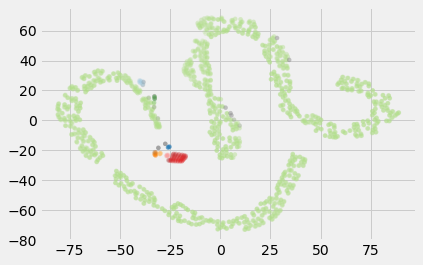

In [294]:
projection = TSNE().fit_transform(X)

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True).fit(X)

color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=20, linewidth=0, c=cluster_member_colors, alpha=0.25)
plt.show()

In [108]:
def plot_distribution(liste):
    
    v_count = dict()
    
    for i in liste:
        if liste[i] in v_count:
            v_count[liste[i]] += 1
        else:
            v_count[liste[i]] = 1
            
    pd.Series(v_count).plot(kind='bar')
    
    return v_count
    
def get_data_from_class(series, labels, num_label):
    
    data = []
    
    for i in range(len(labels)):
        if labels[i] == num_label:
            data.append(series[i])
            
    return data

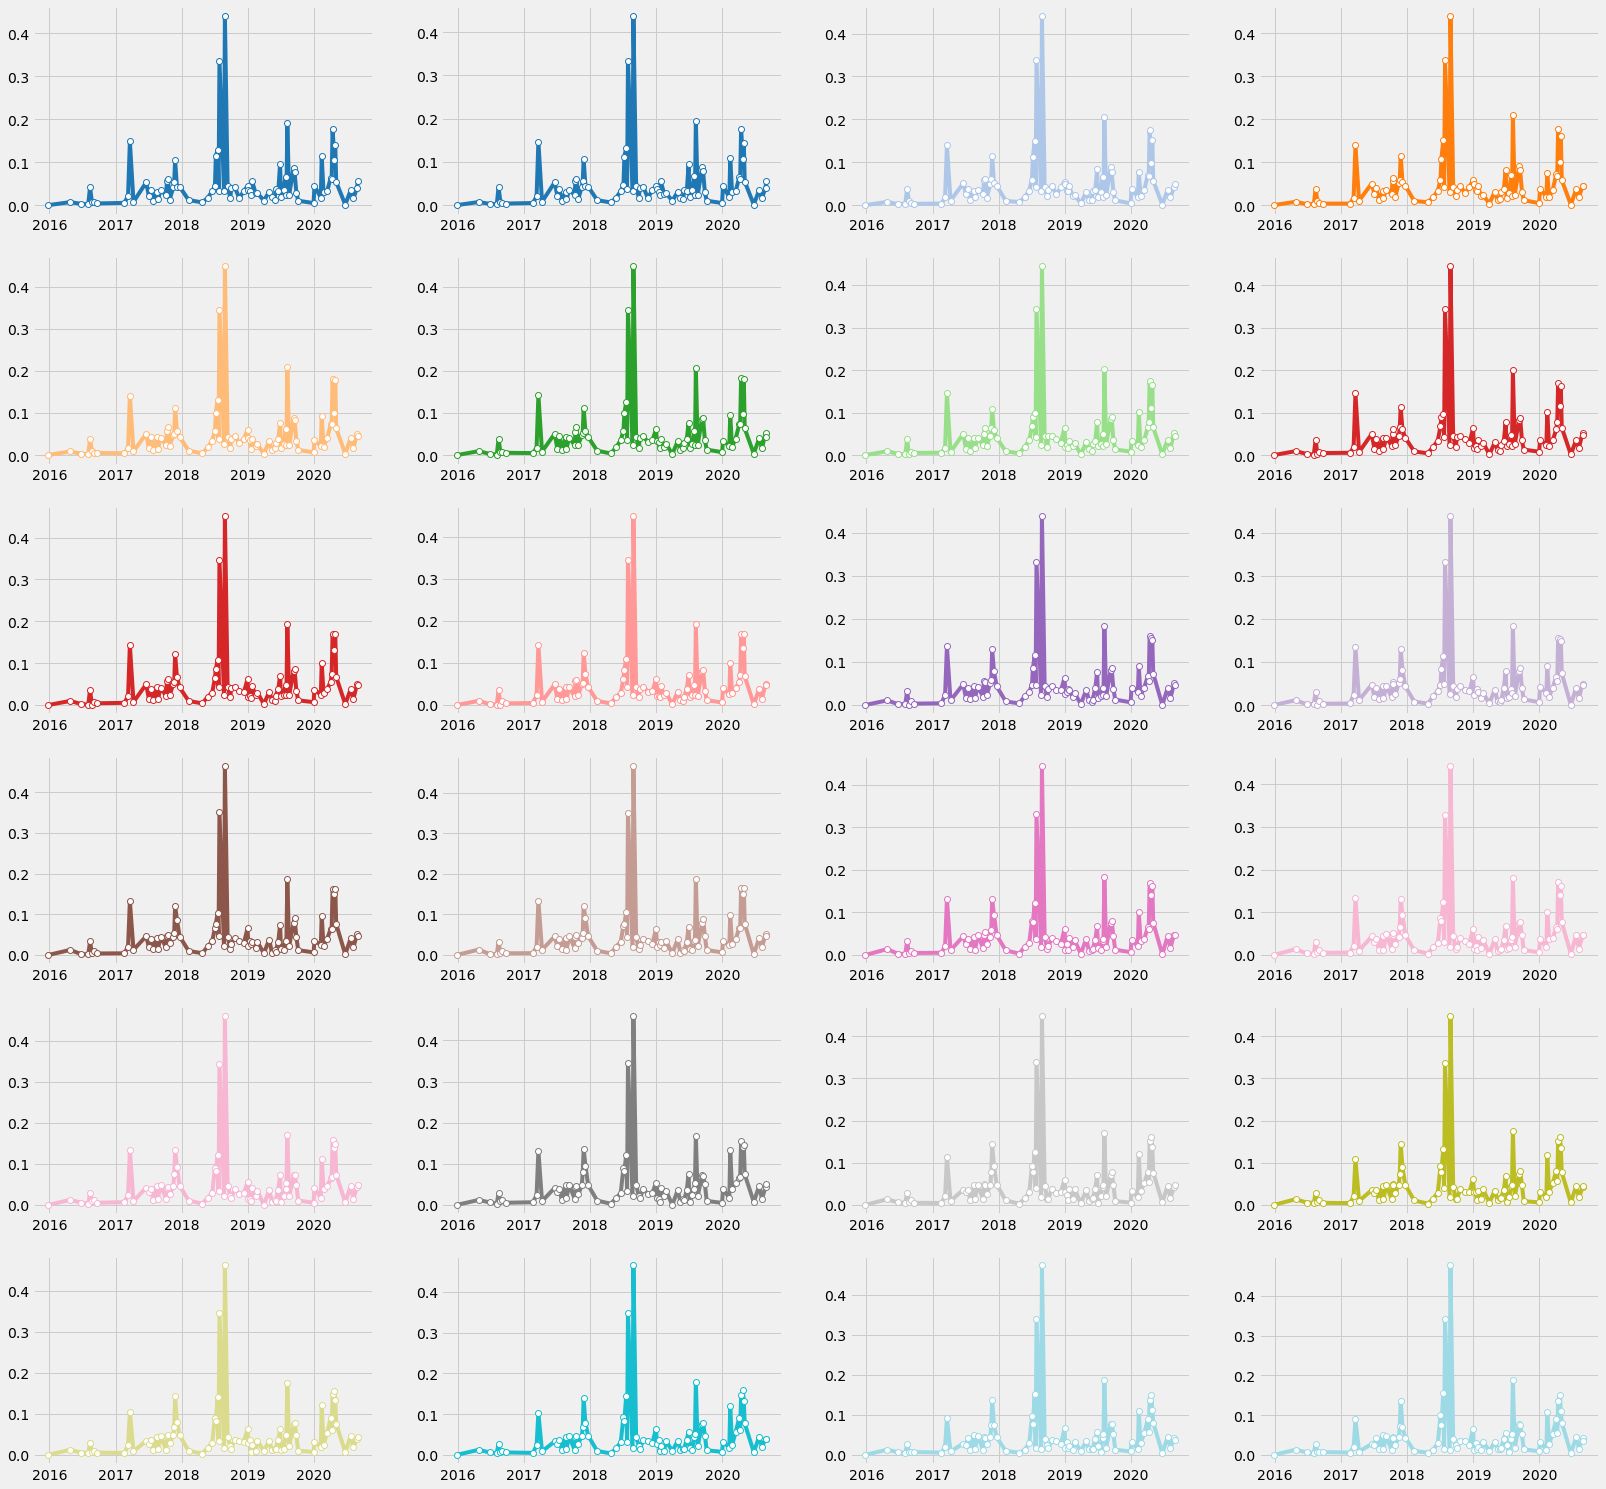

In [295]:
plot_series(get_data_from_class(vel_ts, clusterer.labels_, 2))

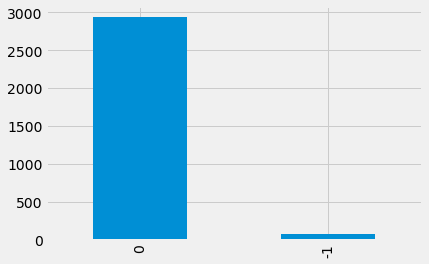

In [292]:
series = plot_distribution(clusterer.labels_)

{2: 2971, -1: 29}

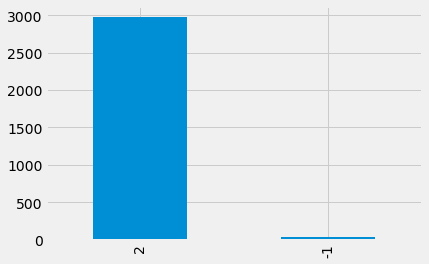

In [112]:
labels = clusterer.labels_
plot_distribution(labels)

## ST-DBSCAN